# Estimating the Proc2D mean in the Cov.-Smoothing Basis

Import libraries.

In [54]:
# Required
library(mgcv)
library(sparseFLMM)
library(dplyr)

# To deal with SRV framework
library(elasdics)

# Plotting
library(ggplot2)
library(gridExtra)
library(viridis)
library(rgl)
library(fields)

# Datasets
source("/home/mnl/Statistik/masterthesis/code/datasets.R")

# Seed 
set.seed(18)

## Prepare Dataset
Load dataset and transform curves to SRV framework.

In [2]:
# Simulate 2D spirals.
data_curves <- curves.spiral(n_curves=4, rotate=TRUE, scale=TRUE, center=TRUE)

# Create arc length parametrization.
data_curves <- lapply(data_curves, function(data_curve) {
    data.frame(t = get_arc_length_param(data_curve), data_curve)
})

# Get SRV data curves.
srv_data_curves <- lapply(data_curves, get_srv_from_points)

# Reparametrize SRV data curves and put curves into long (stacked) format.
t_optims <- lapply(srv_data_curves, function(srv_data_curve) { c(srv_data_curve$t, 1) })
model_data <- elasdics:::get_model_data(t_optims, srv_data_curves, knots=c(), type="smooth")

Transform curves from real plane to complex. Add a curve id column (for the covariance estimation).

In [3]:
# Create curve id column for model_data. (hacky!)
ids <- do.call(c, lapply(t_optims, function(x) length(x)-1))
ids <- rbind(1:length(ids), ids)
ids <- apply(ids, 2, function(x) rep(x[1], times = x[2]))
ids <- do.call(c, as.list(ids))         
             
# x,y to complex. Add id column.
model_data_complex <- complex(re=model_data[,2], im=model_data[,3]) %>% matrix(nrow=dim(model_data)[1])
model_data_complex <- data.frame(id = ids, m_long = model_data$m_long, q_m_long = model_data_complex)

## Estimate Covariance Surface
Build covariance response on (s,t) grid.

In [4]:
cov_dat <- lapply(split(model_data_complex, model_data_complex$id), function(x) {
    combs <- combn(1:nrow(x),2)
    data.frame(
        t = x$m_long[combs[1,]],
        s = x$m_long[combs[2,]],
        qq = x$q_m_long[combs[1,]] * Conj(x$q_m_long[combs[2,]])
    )
})
cov_dat <- do.call(rbind,cov_dat)

Fit covariance surface using ```mgcv```.

In [639]:
# Parameters for covariance smoothing
knots = seq(0,1,length=11) 
cov.m = 0 # basis order (spline degree-1)
cov.d = 1 # penalty
# Using knots
knotl = 1 / ( length(knots) - 1 )  # mean length of a knot
cov.knots = c(rep(-knotl,cov.m+1), knots, rep(1+knotl,cov.m+1))  # asusmes cov.m is 0 or 1.
#cov.knots = c(rep(0,cov.m+1), knots, rep(1,cov.m+1))  # knots at 0,1
cov.k = length(cov.knots) - cov.m - 2 # basis dimension.


# Smooth covariance surface
cov_fit_re <- bam(Re(qq) ~ s(t, s, bs="symm", k = cov.k, m = c(cov.m, cov.d),
                            fx = FALSE, xt = list(skew = FALSE)),
                  data = cov_dat, method = "REML", knots=list(t = cov.knots, s = cov.knots), outer.ok = TRUE)
cov_fit_im <- bam(Im(qq) ~ -1 + s(t, s, bs="symm", k = cov.k, m = c(cov.m, cov.d),
                                  fx = FALSE, xt = list(skew = TRUE)),
                  data = cov_dat, method = "REML", knots=list(t = cov.knots, s = cov.knots), outer.ok = TRUE)

Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"
Warning message in smooth.construct.ps.smooth.spec(eval(as.call(list(as.symbol("s"), :
"there is *no* information about some basis coefficients"


Plot covariance surface on a grid.

In [640]:
# Define covariance surface grid (s,t).
arg.grid = seq(0, 1, len=101)
cov.grid = expand.grid(t = arg.grid, s = arg.grid)
# Evaluate fit on grid.
cov.re = predict(cov_fit_re, newdata = cov.grid)
cov.im = predict(cov_fit_im, newdata = cov.grid)

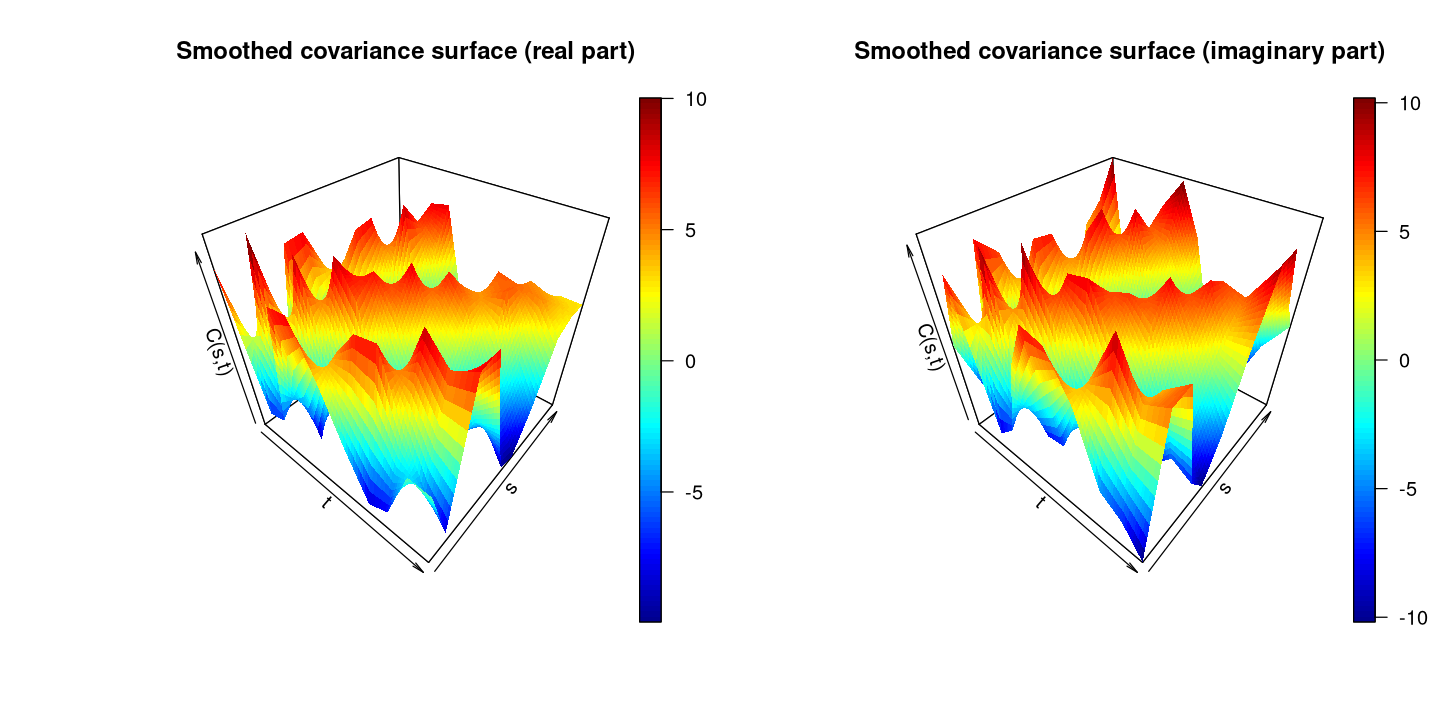

In [641]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
# From 'fdapace/src/R/CreateCovPlot.R'
args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',
    main = 'Smoothed covariance surface (real part)'
)
args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.re,nrow=101))
do.call(plot3D::persp3D, c(args2, args1))

# From 'fdapace/src/R/CreateCovPlot.R'
args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',
    main = 'Smoothed covariance surface (imaginary part)'
)
args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.im,nrow=101))
do.call(plot3D::persp3D, c(args2, args1))

## Estimate Procrustes Mean Shape in fixed Basis

Extract basis functions from covariance smoothing.

Note: Using ```bs="ps"``` here.

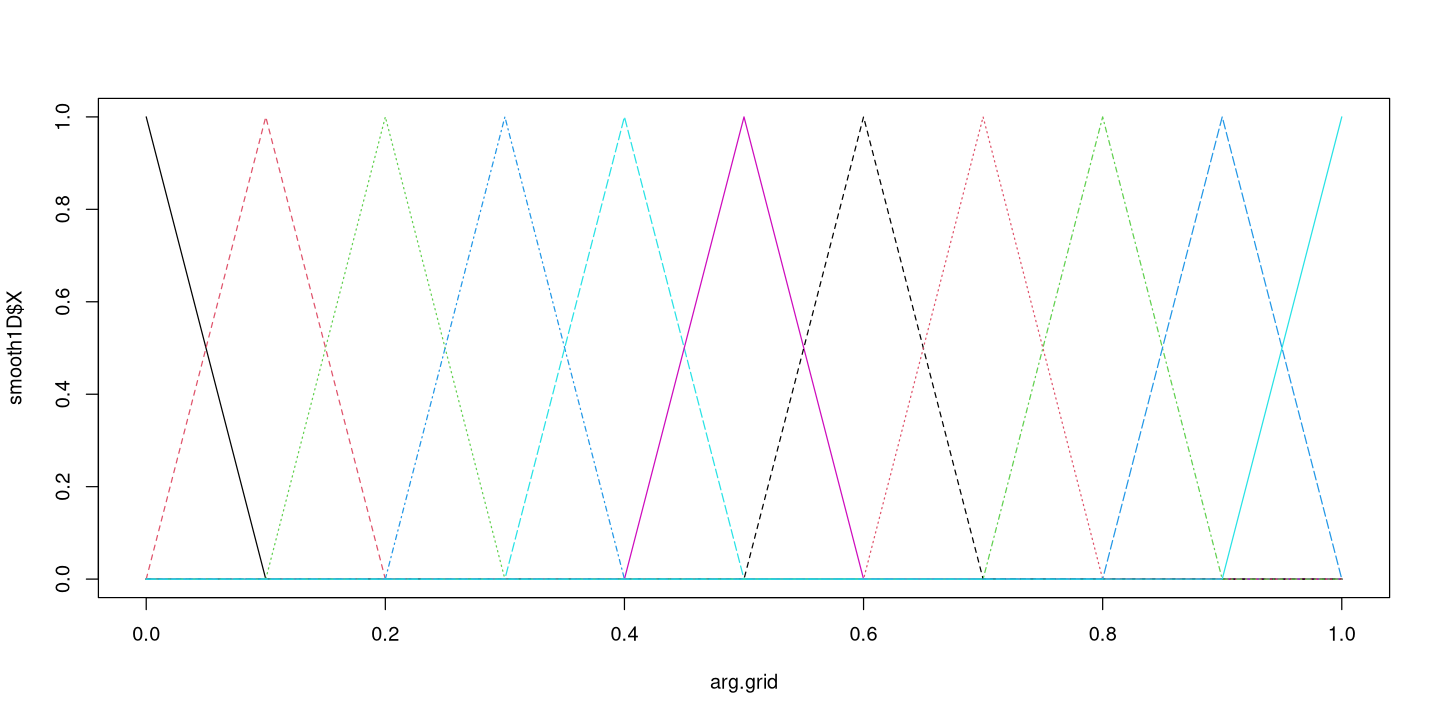

In [642]:
smooth1D <- smooth.construct(s(t, bs="ps", k = cov.k, m = c(cov.m, cov.d),
                              fx = FALSE, xt = list(skew=TRUE)),
                            data = list(t=arg.grid), knots=list(t=cov.knots))
matplot(arg.grid, smooth1D$X, t = "l")

#### Function for extracting tensor product coefficient matrix.

In [643]:
get_coef_matrix <- function(model){
    F <- model$smooth[[1]]$bs.dim
    beta <- model$smooth[[1]]$Z %*% model$coefficients
    matrix(beta, nrow=F, ncol=F)
}

In [644]:
build_gram_matrix <- function(smooth){
    order = smooth$m[1] + 2  # degree + 1
    knots = smooth$knots  # inner+outer knots
    if( order == 1 ){
        diag(smooth$bs.dim)
    } else {
        osb_smooth = orthogonalsplinebasis::SplineBasis(knots,order=order)
        orthogonalsplinebasis::GramMatrix(osb_smooth)
    }
}

G <- build_gram_matrix(smooth1D)

In [645]:
beta.mat.re <- get_coef_matrix(cov_fit_re)
beta.mat.im <- get_coef_matrix(cov_fit_im)

beta.mat <- matrix( 
    complex(real = as.vector(beta.mat.re), imaginary = as.vector(beta.mat.im)),
    ncol = cov.k)

In [646]:
# Calculate largest eigenvector
coefs.mean <- eigen(t(chol(solve(G))) %*% beta.mat %*% chol(solve(G)))$vectors[,1]

In [647]:
qt <- smooth1D$X %*% coefs.mean
xt <- Re(qt)
yt <- Im(qt)

qt.xy <- data.frame(t=arg.grid, X1=xt, X2=yt)
bt.xy <- get_points_from_srv(qt.xy)

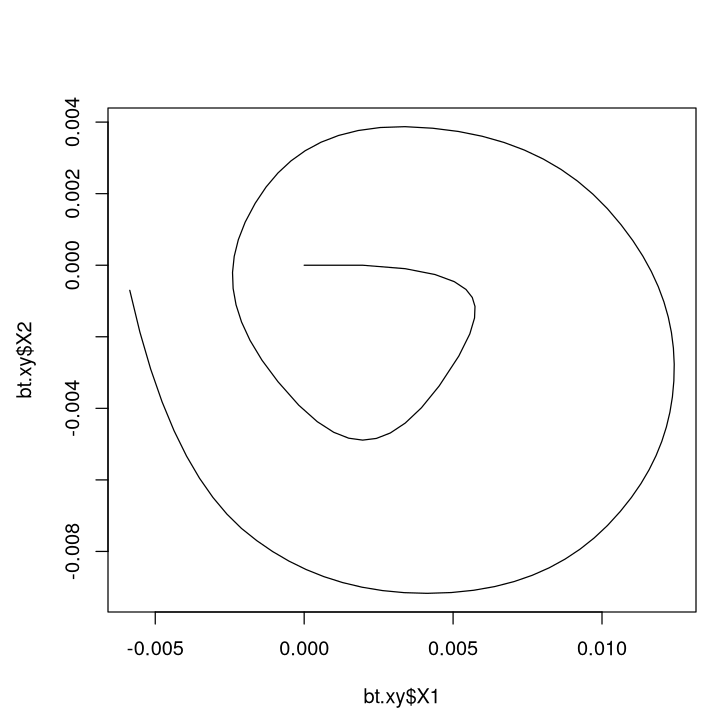

In [648]:
options(repr.plot.width=6, repr.plot.height=6)
par(mfrow=c(1,1), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
matplot(bt.xy$X1, bt.xy$X2, t="l")

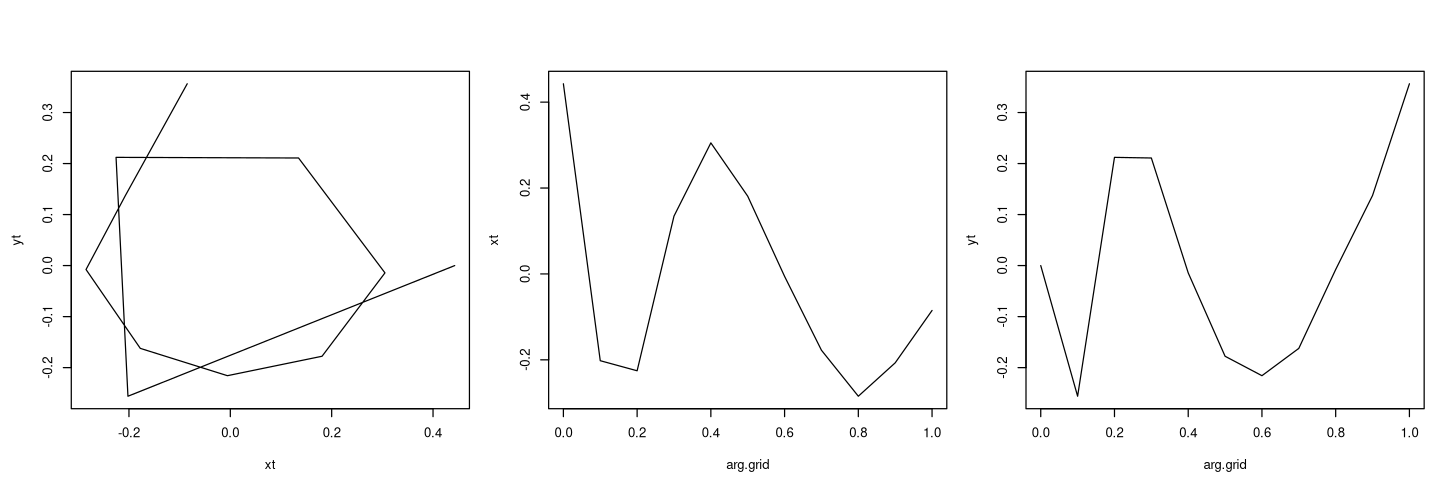

In [649]:
options(repr.plot.width=12, repr.plot.height=4)
par(mfrow=c(1,3), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
matplot(xt,yt,t="l")
matplot(arg.grid, xt, t="l")
matplot(arg.grid, yt, t="l")

### Plot Procrustes Fits + Mean from fixed basis (Note: No warping!)
Note: this is super hacky and just for illustration purposes. ^_^

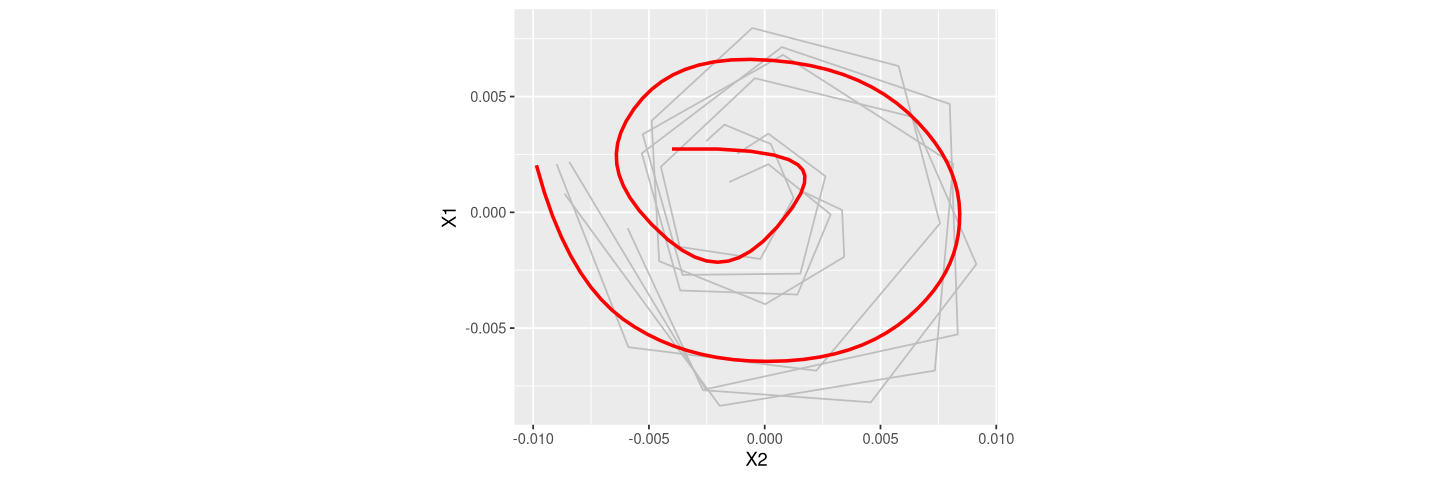

In [650]:
bt.xy <- center_curve(bt.xy)

align_curve_proc2d <- function(data_curve, mean){
    mean_coefs = as.matrix(mean)
    mean_eval = elasdics:::make_design(arg.grid, knots = seq(0,1,length = 102)) %*% mean_coefs
    mean_eval = complex(real = mean_eval[,2], imaginary = mean_eval[,1])
    b_coefs <- as.matrix(data_curve[,-1])
    b_eval <- elasdics:::make_design(arg.grid, knots = data_curve$t) %*% b_coefs
    b_eval <- complex(real = b_eval[,1], imaginary = b_eval[,2])
    bm <- Conj(b_eval) %*% mean_eval
    bb <- Conj(b_eval) %*% b_eval
    # Apply rotation+scaling to original curve, return.
    b_compl <- complex(real = b_coefs[,1], imaginary = b_coefs[,2])
    pfit <- as.vector(bm) * b_compl / as.vector(bb)
    data.frame(t = data_curve$t, X1 = Re(pfit), X2 = Im(pfit))
}

pfits <- lapply(data_curves, function(x) {
    pfit <- align_curve_proc2d(x, bt.xy)
    center_curve(pfit)
})

ggplot(bind_rows(pfits, .id="id"), aes(x=X2, y=X1)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=bt.xy, aes(x=X1, y=X2), color = "red", size = 1) +
    coord_fixed()